# 基于 MindSpore Quantum 实现 Adapt Clifford 算法求解 Maxcut 问题

## 1 问题背景：

使用变分算法求解最大割问题面临训练成本高等问题，如果可以使用 Clifford 线路模拟求解最大割问题，就可以在经典计算机上高效求解。

## 2 项目任务及实现方案：

本项目的核心任务是实现浅层Clifford线路的 Adapt_Clifford 算法，启发来自 Adapt_QAOA，当把标准层Rzz门及参数$\gamma^{(n)}$删去之后，仅使用混合层实现优化。发现线路只选取 YZ ZY 算符，并且混合层参数$\beta^{(n)}=\pm \frac{\pi}{4}$, 由此可看出 Clifford 线路求解 MaxCut 问题的潜力。

## 3 Adapt Clifford 算法描述：
![circ](./fig.png)

从$|+\rangle^{\otimes N}$出发，随机选择一个初始比特t作用Z门，并将其标记为__激活比特__，其余N-1为__待激活比特__。从t出发开始计算算子池中每个算子的梯度，选择梯度值变化最大的那个算子，将其填入到线路中。每层添加一个Ryz门，同时激活一个比特，直到所有比特激活，因此只需N-1个Ryz门。

Randomized 方法：随机选择一个比特

Deterministic 方法：遍历所有比特，输出能量值最小的

#### 1.1 生成一个MaxCut问题

这里为Complete Graph，先定义一个邻接矩阵，权重为Uniform(0,1)分布。

通过openqaoa的ground_state_hamiltonian接口求得其基态能量。最后计算出它的哈密顿量 $H_c=(\frac{1}{2})\sum_{i<j}Z_{i}Z_{j}$。

In [1]:
import numpy as np

def adj_matrix_complete(nodes):
    mat = np.zeros((nodes, nodes))
    for ii in range(nodes):
        for jj in range(nodes):
            if jj > ii: mat[ii, jj] = np.random.uniform(0, 1)
    return mat + mat.T

In [2]:
import networkx as nx
from openqaoa.utilities import ground_state_hamiltonian
from openqaoa.problems import MaximumCut
from mindquantum.core.operators import QubitOperator

def get_ham(nodes, W, ground=True):
    G = nx.from_numpy_array(W)
    
    if ground:  # ground_state_hamiltonian 接口建议nodes <= 20,大比特下无法求解，所以定义为一个选项
        energy, configuration = ground_state_hamiltonian(MaximumCut(G).qubo.hamiltonian)
        print(f"Ground State energy: {energy/2}, Gonfiguration: {configuration}")

    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    ham = QubitOperator()
    for w, (i, j) in zip(weights, edges):
        ham += QubitOperator(f'Z{i} Z{j}', w / 2)
    return ham

#### 1.2 对当前线路施加的门计算梯度

$Grad_{mixer} = \displaystyle -i\langle \psi\,|[H_c,\,mixer]|\,\psi\rangle$

In [3]:
from mindquantum.simulator import Simulator
from mindquantum.core.operators import Hamiltonian

def get_exp(circ, ham, sim):
    exp = sim.get_expectation(Hamiltonian(ham), circ)
    sim.reset()
    return exp

In [4]:
from mindquantum.core.operators import commutator
def derivative(ham, mixer, circ, sim):
    commu = (-1j) * commutator(ham, QubitOperator(mixer))
    expectation = get_exp(circ, commu, sim)
    sim.reset()
    return expectation

#### 1.3 提取字符串形式mixer中的数字

k, j = extract_numbers('Ak Bj')

In [5]:
import re
def extract_numbers(s):
    match = re.match(r'(\D+)(\d+) (\D+)(\d+)', s)
    if match:
        n = int(match.group(2))
        m = int(match.group(4))
        return n, m

#### 1.4 添加一层分解形式的 Ryz 门

$e^{i \frac{\pi}{4} Y_l Z_m} = S_lH_m CNOT_{l,m} RX_l (-\frac{\pi}{2}) CNOT_{l,m} S^\dagger_lH_m$

In [6]:
from mindquantum.core.gates import H, Z, X, CNOT, S

def add_layer(circ, l, m):
    circ += Z.on(l)
    circ += S.on(l)

    circ += H.on(m)
    circ.barrier()
    circ += CNOT(m, l)
    circ.barrier()

    circ += Z.on(l)
    circ += S.on(l)
    circ += Z.on(l)
    circ += H.on(l)
    circ += Z.on(l)
    circ += S.on(l)
    circ += Z.on(l)

    circ.barrier()
    circ += CNOT(m, l)
    circ.barrier()
    circ += S.on(l)

    circ += H.on(m)
    circ.barrier()

#### 1.5 Adapt_Clifford 算法

In [7]:
from mindquantum.core.circuit import Circuit
from mindquantum.simulator import Simulator

def adapt_clifford(nodes, t, ham):
    all_qubits = list(range(nodes))
    sim = Simulator('stabilizer', nodes) # 定义stabilizer模拟器
    
    layer = 0

    aqubits = [t]  # 初始随机激活一个比特 t∈[0, nodes)
    inaqubits = [n for n in all_qubits if n != t]
    mixers = [f'Y{i} Z{j}' for i in aqubits for j in inaqubits] # 第一层的mixer集

    circ = Circuit().un(H,range(nodes)).z(t) #初始线路

    mixers_used = [] # 所有添加的mixer
    while True:
        gradients = []
        for mixer in mixers:
            gradients.append(derivative(ham, mixer, circ, sim)) # 对当前mixer集求梯度
        target_mixer = mixers[np.argmax(gradients)] # 找到使哈密顿量梯度下降最大的那个mixer
        mixers_used.append(target_mixer)
        
        # 新激活的比特为 j
        if layer == 0:
            k, j = extract_numbers(target_mixer) 
            add_layer(circ, k, j)
        if layer > 0:
            k, j = extract_numbers(target_mixer) 
            add_layer(circ, j, k)

        aqubits.append(j)
        inaqubits.remove(j)

        mixers = [f'Z{i} Y{j}' for i in aqubits for j in inaqubits] # 后面层的mixer集
        layer += 1
        
        if layer == nodes - 1: # 对于一个n比特问题，只需n-1层
            return get_exp(circ, ham, sim), circ, mixers_used

### 实例测试

In [8]:
nodes = 10
W = adj_matrix_complete(nodes)
ham = get_ham(nodes, W, ground=True)

Ground State energy: -3.4640045792129825, Gonfiguration: ['0110010110', '1001101001']


#### Randomized 方法

In [9]:
import random

t = random.choice(range(nodes))
res, circ, mixers_used = adapt_clifford(nodes, t, ham)
print(t, res)
print(mixers_used)

1 -3.178392099684092
['Y1 Z6', 'Z1 Y0', 'Z6 Y3', 'Z6 Y4', 'Z1 Y8', 'Z6 Y7', 'Z1 Y9', 'Z6 Y5', 'Z1 Y2']


#### Deterministic 方法

In [10]:
res_lst = []
for t in range(nodes):
    res, circ, mixers_used = adapt_clifford(nodes, t, ham)
    print(t, res)
    res_lst.append(res)
print("the minimum energy:", min(res_lst))

0 -3.4640045792129825
1 -3.178392099684092
2 -3.4640045792129825
3 -3.178392099684092
4 -3.178392099684092
5 -3.4640045792129825
6 -3.178392099684092
7 -3.3573582063718774
8 -3.3573582063718774
9 -3.4640045792129825
the minimum energy: -3.4640045792129825


## 4 热启动 warm state：

通过经典的半正定规划，Burer-Monteiro 降秩方法得到一个粗解，并由此初态开始进行优化。已证明热启动能有效地提高 QAOA 和 Adapt QAOA 算法的精度。优化的矩阵可看做为N个二维(k=2)或三维(k=3)向量，分别对应着N个比特，将每个比特制备成所对应向量的初态，即可实现warm state。请注意，单位圆(k=2)与单位球(k=3)中，量子态采样结果与随机超平面法不同，采样结果取决于所有态的位置，所以在制备warm state前，需要通过全局旋转：随机选择一个态将其旋转到$|0\rangle$上，分别求能量，选择能量值最低的那个初态。

！！由于在Clifford线路中无法实现随机参数，所以通过热启动得到一个0/1串，将其制备成初态。

## 5 Burer-Monteiro 方法：

半正定规划求解 MaxCut 问题的形式为：
$$miximize\,\,\langle -A, X^T X \rangle$$
$$subject\,\,to\,\,||x_i||_2=1, \forall i \in [n]$$
$$x_i \in \mathbb{R}^n, \forall i \in [n]$$
当n=N的时候，即为Geomans-Williamson算法。而当n=k<<N的时候即为Burer-Monteiro 方法。通过将秩降到k=2,3，可实现粗略求解。

## 6 验证 warm Adapt Clifford 算法可行性：

结论：我们发现，由热启动得到的0/1态，将$|1\rangle$视为__伪激活比特__，并从$|1\rangle$中随机选择一个比特_x_作为初始比特进行求解，其解等于 adapt_clifford(x) 的解。并且0串的解集与1串的解集互补，共同组成原deterministic方法的解集，并一一对应。进一步我们发现，不管是randomized方法还是deterministic方法，热启动的解对0/1串无指向性，对长/短无指向性。即：无法通过热启动来缩小初始比特作用的位置而缩小deterministic方法的随机性。

#### 2.1 Burer-Monteiro 方法

In [11]:
import pymanopt
import autograd.numpy as anp
from pymanopt.manifolds import Product
from pymanopt.optimizers import TrustRegions

def burer_monteiro_method(adj_matrix, nodes, k):
    # Define Product manifolds
    manifold = Product([pymanopt.manifolds.Sphere(k) for _ in range(nodes)])

    @pymanopt.function.autograd(manifold)
    # Define the cost function
    def objective(*X):
        X = anp.stack(X, axis=0)  # matrix form
        return anp.trace(adj_matrix @ (X @ X.T))

    problem = pymanopt.Problem(manifold, objective)
    optimizer = TrustRegions(max_iterations=1000, min_gradient_norm=1e-6, verbosity=0)
    result = optimizer.run(problem)
    X_opt = anp.stack(result.point, axis=0)
    return X_opt

#### 2.2 粗解0/1串

In [12]:
def get_cut(X_op, adj_matrix, num_samples):
    #
        # 得到的cut一定能消除对称性与平衡性
    #
    n, k = X_op.shape
    best_cut = None
    best_cut_value = -np.inf
    for _ in range(num_samples):
        r = np.random.randn(k)
        r /= np.linalg.norm(r)
        x = np.sign(X_op @ r)

        cut_value = np.sum(adj_matrix * (x[:, None] != x)) // 2
        if cut_value > best_cut_value:
            best_cut_value = cut_value
            best_cut = x.copy()

    if np.sum(best_cut == 1) == np.sum(best_cut == -1):
        best_cut[np.random.choice(n)] *= -1     # 消除平衡性
    if best_cut[0] == -1:
        best_cut = -best_cut        # 消除对称性
    return [0 if x == -1 else 1 for x in best_cut]

#### 2.3 分别提取0/1串中0的索引和1的索引

In [13]:
def get_targets(cut):
    indices_0 = [i for i, x in enumerate(cut) if x == 0]
    indices_1 = [i for i, x in enumerate(cut) if x == 1]
    return indices_0, indices_1

#### 2.4 制备定性的初态及粗解的能量值

In [14]:
def warm_state_qualitative(target_qubits, ham, nodes, sim):
    circ = Circuit().un(X, target_qubits)
    exp = get_exp(circ, ham, sim)
    circ.un(H, range(nodes))
    circ.barrier()
    return circ, exp

#### 2.5 warm_adapt_clifford

In [15]:
import copy
def warm_adapt_clifford(nodes, t, ham, circ_warm):
    all_qubits = list(range(nodes))
    sim = Simulator('stabilizer', nodes)
    
    layer = 0
    circ = copy.deepcopy(circ_warm)
    
    aqubits = [t]
    inaqubits = [n for n in all_qubits if n != t]
    mixers = [f'Y{i} Z{j}' for i in aqubits for j in inaqubits]
    mixers_used = []
    while True:
        gradients = []
        for mixer in mixers:
            gradients.append(derivative(ham, mixer, circ, sim))
        target_mixer = mixers[np.argmax(gradients)]
        mixers_used.append(target_mixer)
        
        if layer == 0:
            k, j = extract_numbers(target_mixer)
            add_layer(circ, k, j)
        if layer > 0:
            k, j = extract_numbers(target_mixer)
            add_layer(circ, j, k)

        aqubits.append(j)
        inaqubits.remove(j)

        mixers = [f'Z{i} Y{j}' for i in aqubits for j in inaqubits]
        layer += 1
        if layer == nodes - 1:
            return get_exp(circ, ham, sim), circ, mixers_used

### 实例测试

In [16]:
nodes = 15
W = adj_matrix_complete(nodes)
ham = get_ham(nodes, W, ground=True)

Ground State energy: -6.520889802257112, Gonfiguration: ['001101110001110', '110010001110001']


In [17]:
%%time
res = []
print("deterministic method:")
for t in range(nodes):
    value,_,_ = adapt_clifford(nodes, t, ham)
    print(t, value)
    res.append(value)
print(f'the minimum energy: {min(res)}')

deterministic method:
0 -6.460736322966745
1 -6.460736322966745
2 -6.460736322966745
3 -6.460736322966745
4 -6.206584078307759
5 -6.206584078307759
6 -6.206584078307759
7 -6.520889802257112
8 -6.460736322966745
9 -6.460736322966745
10 -6.460736322966745
11 -6.460736322966745
12 -6.520889802257112
13 -6.460736322966745
14 -6.460736322966745
the minimum energy: -6.520889802257112
CPU times: total: 15.9 s
Wall time: 15.9 s


In [18]:
X_op = burer_monteiro_method(W, nodes, 3)
cut = get_cut(X_op, W, num_samples=100)
target_0, target_1 = get_targets(cut)
print(f'0-string target qubits: {target_0}\n1-string target qubits: {target_1}')
sim = Simulator('stabilizer', nodes)
circ_warm0, exp_warm0 = warm_state_qualitative(target_0, ham, nodes, sim)
circ_warm1, exp_warm1 = warm_state_qualitative(target_1, ham, nodes, sim)
print("the initial energy:",exp_warm0,exp_warm1)

0-string target qubits: [2, 3, 5, 6, 7, 11, 12, 13]
1-string target qubits: [0, 1, 4, 8, 9, 10, 14]
the initial energy: -6.520889802257112 -6.520889802257112


In [19]:
res0 = []
print("0-string warm:")
for t in target_0:
    value0,_,_ = warm_adapt_clifford(nodes, t, ham, circ_warm0)
    print(t, value0)
    res0.append(value0)

0-string warm:
2 -6.460736322966745
3 -6.460736322966745
5 -6.206584078307759
6 -6.206584078307759
7 -6.520889802257112
11 -6.460736322966745
12 -6.520889802257112
13 -6.460736322966745


In [20]:
res1 = []
print("1-string warm:")
for t in target_1:
    value1,_,_ = warm_adapt_clifford(nodes, t, ham, circ_warm1)
    print(t, value1)
    res1.append(value1)

1-string warm:
0 -6.460736322966745
1 -6.460736322966745
4 -6.206584078307759
8 -6.460736322966745
9 -6.460736322966745
10 -6.460736322966745
14 -6.460736322966745


In [21]:
# 合并整合，验证结论
dct_deterministic = {i:res[i] for i in range(nodes)}

dct_0string = {target_0[i]:res0[i] for i in range(len(target_0))}
dct_1string = {target_1[i]:res1[i] for i in range(len(target_1))}
merged_dict = {**dct_0string, **dct_1string}
sorted_dict = {k: merged_dict[k] for k in sorted(merged_dict)}

print("deterministic result:", dct_deterministic)
print("0/1str merged result:",sorted_dict)
print("0串结果与1串结果是互补的两个子集，其值分别对应deterministic方法的结果！")

deterministic result: {0: -6.460736322966745, 1: -6.460736322966745, 2: -6.460736322966745, 3: -6.460736322966745, 4: -6.206584078307759, 5: -6.206584078307759, 6: -6.206584078307759, 7: -6.520889802257112, 8: -6.460736322966745, 9: -6.460736322966745, 10: -6.460736322966745, 11: -6.460736322966745, 12: -6.520889802257112, 13: -6.460736322966745, 14: -6.460736322966745}
0/1str merged result: {0: -6.460736322966745, 1: -6.460736322966745, 2: -6.460736322966745, 3: -6.460736322966745, 4: -6.206584078307759, 5: -6.206584078307759, 6: -6.206584078307759, 7: -6.520889802257112, 8: -6.460736322966745, 9: -6.460736322966745, 10: -6.460736322966745, 11: -6.460736322966745, 12: -6.520889802257112, 13: -6.460736322966745, 14: -6.460736322966745}
0串结果与1串结果是互补的两个子集，其值分别对应deterministic方法的结果！


### 进一步验证

为了进一步验证warm_adapt_clifford的可行性，取消原本 adapt_clifford 算法__激活/待激活__比特这一概念，定制一个全集池子pool，自行定义线路深度 layers，从 circ_warm 开始自行计算梯度 并添加逻辑门。取N=10，layers=15，并与randomized 方法进行对比，结果发现 circ_warm最终优化值 或大于 或小于 或等于 初始启动值，而且这个值始终无法到达 精确基态能量。

#### 2.6 mixer池

In [22]:
from itertools import product
# 包含所有 YZ ZY算子
def mixer_pool(nodes):
    number_pairs = [f'{i}{j}' for i in range(nodes) for j in range(i + 1, nodes)]
    letter_pairs = ['Y Z', 'Z Y']
    pool = [f'{let[0]}{num[0]} {let[2]}{num[1]}' for num, let in product(number_pairs, letter_pairs)]
    return pool

#### 2.7 提取辅助函数

In [23]:
def extract(s):
    match = re.match(r'(\D+)(\d+) (\D+)(\d+)', s)
    if match:
        n = int(match.group(2))
        m = int(match.group(4))
        p = str(match.group(1))
        q = str(match.group(3))
        return (n, m), (p+q)

#### 2.8 warm_adapt_clifford_with_pool

In [24]:
def test_warm_adapt_clifford(nodes, ham_op, circ_warm, exp_warm, pool, layers):

    layer = 0
    sim = Simulator('stabilizer', nodes)
    circ = copy.deepcopy(circ_warm)
    values = [exp_warm]
    mixers_used = []

    while True:
        gradients = []
        for mixer in pool:
            gradients.append(derivative(ham, mixer, circ, sim))
        mixer = pool[np.argmax(gradients)]
        mixers_used.append(mixer)

        (k, j), s = extract(mixer)
        if s == 'YZ':
            add_layer(circ, k, j)
        if s == 'ZY':
            add_layer(circ, j, k)

        values.append(get_exp(circ, ham, sim))
        layer += 1
        if layer == layers:
            return values,mixers_used

### 进一步验证结果

结论：热启动方法无法与adapt_clifford算法相结合。原因在于，由热启动得到的 定性0/1串的初态 warm_state_qualitative，一开始具有一个较好的初始能量，但对每个比特施加Hadamard门之后 能量值又回归于0，使其无法提取到热启动的信息。所以要保持热启动信息，就不能施加Hadamard门，在此基础上，就无法使用只能在$|\pm\rangle$空间中求解的adapt_clifford算法。

由文献Warm-starting quantum optimization中可知，对于一个warm-state，其最优路径是 adjusted_mixer，而这个混合层无需使用纠缠逻辑门。所以 从该定性初态出发进行求解的最佳算法 为贪心算法。

In [33]:
nodes = 10
W = adj_matrix_complete(nodes)
ham = get_ham(nodes, W, ground=False)

G = nx.from_numpy_array(W)
energy, _ = ground_state_hamiltonian(MaximumCut(G).qubo.hamiltonian)
energy = energy / 2

X_op = burer_monteiro_method(W, nodes, 3)
cut = get_cut(X_op, W, num_samples=100)
target_0, target_1 = get_targets(cut)
circ_warm0, exp_warm0 = warm_state_qualitative(target_0, ham, nodes, sim)
circ_warm1, exp_warm1 = warm_state_qualitative(target_1, ham, nodes, sim)

In [34]:
circ_standard = Circuit().un(H, range(nodes)).z(random.choice(list(range(nodes))))  # 标准启动

pool = mixer_pool(nodes)
layers = 15  # 自定义线路深度

In [35]:
values0,_ = test_warm_adapt_clifford(nodes, ham, circ_warm0, exp_warm0, pool, layers)
values1,_ = test_warm_adapt_clifford(nodes, ham, circ_warm1, exp_warm1, pool, layers)
values,_ = test_warm_adapt_clifford(nodes, ham, circ_standard, 0, pool, layers)

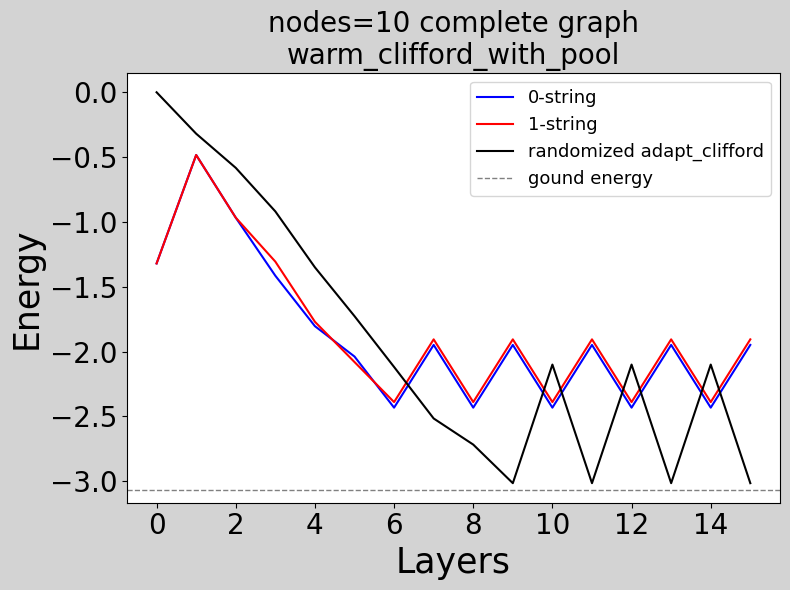

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), facecolor='lightgray')
plt.plot(list(range(layers+1)),values0,color='b',label='0-string')
plt.plot(list(range(layers+1)),values1,color='r',label='1-string')
plt.plot(list(range(layers + 1)), values, color='black', label='randomized adapt_clifford')
plt.axhline(energy, color='gray', linestyle='--', linewidth=1,label='gound energy')

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title(f'nodes=10 complete graph\nwarm_clifford_with_pool', fontsize=20)
plt.xlabel('Layers', fontsize=25)
plt.ylabel('Energy', fontsize=25)
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

## 7 Adapt Clifford 算法的改写与封装

上述 Adapt Clifford 算法 是通过计算对易式来求解梯度值，此方法在大比特实例中会产生大量的无效计算，导致运行时间过长。通过对大量实例的结果进行分析，因此这里对其进行代数方法的修改，使其能模拟更大比特的MaxCut问题。

！！此代数法计算梯度来源于文献Muñoz-Arias M H, Kourtis S, Blais A. Low-depth Clifford circuits approximately solve MaxCut. Physical Review Research, 2024, 6(2): 023294.

！！仅梯度计算使用与 MaxCut 问题

#### 3.1 梯度计算

我们发现，在第一层确定两个激活比特k,j后，后续所有的Ryz门中的激活比特部分一定会从k,j中选取。根据此Clifford线路的特殊性，当选取某个待激活比特的时候，计算其对应的梯度。

In [37]:
def gradient(inaqubit, W, aqubits_k, aqubits_j):
    """
    Given an inactive qubit, this function computes the gradient of it with
    with respect to the two qubits defining the bipartition.

    inaqubit: the inactibe qubit under consideration
    W: a matrix of the edge weights
    aqubits_k: the active qubits which were entangled with qubit k
    aqubits_j: the active qubits which were entangled with qubit j
    """

    lindex_k = np.intersect1d(np.nonzero(W[:, inaqubit])[0], aqubits_k)
    lindex_j = np.intersect1d(np.nonzero(W[:, inaqubit])[0], aqubits_j)

    sum_weights_k = np.sum(W[ll, inaqubit] for ll in lindex_k)
    sum_weights_j = np.sum(W[ll, inaqubit] for ll in lindex_j)

    grad_k = -sum_weights_k + sum_weights_j
    return grad_k

#### 3.2 梯度筛选

计算得出使梯度下降最大的那个 待激活比特，并筛选出需要作用的Ryz门

In [38]:
def pos_max_grad(inaqubits, W, aqubits_k, aqubits_j):
    """
    This function finds the inactive qubit b with the largest gradient, and the
    corresponding initial qubit, k or j, with which this largest gradient occurs

    inaqubits: the vector of inactive qubits
    W: a matrix of the edge weights
    aqubits_k: the active qubits which were entangled with qubit k
    aqubits_j: the active qubits which were entangled with qubitt j
    """

    all_grads_k = [gradient(inaqubit, W, aqubits_k, aqubits_j) for inaqubit in inaqubits]
    all_grads_j = -1.0 * np.array(all_grads_k)

    pos_max_k = np.argmax(all_grads_k)
    pos_max_j = np.argmax(all_grads_j)

    if all_grads_k[pos_max_k] > all_grads_j[pos_max_j]:
        return "k", inaqubits[pos_max_k], all_grads_k[pos_max_k]
    elif all_grads_k[pos_max_k] < all_grads_j[pos_max_j]:
        return "j", inaqubits[pos_max_j], all_grads_j[pos_max_j]
    else:
        char = np.random.choice([1, 2])
        if char == 1:
            return "k", inaqubits[pos_max_k], all_grads_k[pos_max_k]
        elif char == 2:
            return "j", inaqubits[pos_max_j], all_grads_j[pos_max_j]

#### 3.3 Adapt Clifford 算法(优化)

In [39]:
def adapt_clifford_mq(nodes, t, ham, W):
    circ = Circuit().un(H,range(nodes)).z(t)  # 线路初始化
    sim = Simulator('stabilizer', nodes)
    active_qubits_k = [t]  # 初始激活比特 t
    active_qubits_j = []
    inactive_qubits = [n for n in list(range(nodes)) if n != t]

    mixers_used = []

    d = max(range(len(W)), key=lambda x: W[x][t]) # 第一层的目标比特

    for nn in range(nodes - 1):
        if nn == 0:
            target_qubit = d

            gra = W[target_qubit, t]
            qubits, grad = (t, target_qubit), gra

            active_qubits_j.append(target_qubit)

            inactive_qubits.remove(target_qubit)
        else:
            aset, target_qubit, _ = pos_max_grad(inactive_qubits, W, active_qubits_k, active_qubits_j)

            if aset == "k":
                qubits = (target_qubit, t)
                active_qubits_k.append(target_qubit)
            elif aset == "j":
                qubits = (target_qubit, active_qubits_j[0])
                active_qubits_j.append(target_qubit)
            inactive_qubits.remove(target_qubit)

        add_layer(circ, qubits[0], qubits[1])
        mixers_used.append(qubits)

    return get_exp(circ, ham, sim), circ, mixers_used

### 实例测试

In [40]:
nodes = 10
W = adj_matrix_complete(nodes)
ham = get_ham(nodes, W, ground=True)

Ground State energy: -3.3476198775169737, Gonfiguration: ['1101001100', '0010110011']


In [41]:
# 与优化前的算符比较
for t in range(nodes):
    res, _, _ = adapt_clifford(nodes, t, ham)
    res_mq, _, _ = adapt_clifford_mq(nodes, t, ham, W)
    print(t, res, res_mq)
print("不改变结果")

C:\Users\Admin\AppData\Local\Temp\ipykernel_18296\628900130.py:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_weights_k = np.sum(W[ll, inaqubit] for ll in lindex_k)
C:\Users\Admin\AppData\Local\Temp\ipykernel_18296\628900130.py:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_weights_j = np.sum(W[ll, inaqubit] for ll in lindex_j)


0 -3.0109445037259794 -3.0109445037259794
1 -3.3476198775169737 -3.3476198775169737
2 -3.0109445037259794 -3.0109445037259794
3 -3.0109445037259794 -3.0109445037259794
4 -3.3476198775169737 -3.3476198775169737
5 -3.3476198775169737 -3.3476198775169737
6 -3.3476198775169737 -3.3476198775169737
7 -3.3476198775169737 -3.3476198775169737
8 -3.3476198775169737 -3.3476198775169737
9 -3.3476198775169737 -3.3476198775169737
不改变结果


In [42]:
%%time
## 大比特测试
nodes = 200
W = adj_matrix_complete(nodes)
ham = get_ham(nodes, W, ground=False)

res_mq, _, _ = adapt_clifford_mq(nodes, t, ham, W)
print("energy:", res_mq)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18296\628900130.py:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_weights_k = np.sum(W[ll, inaqubit] for ll in lindex_k)
C:\Users\Admin\AppData\Local\Temp\ipykernel_18296\628900130.py:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_weights_j = np.sum(W[ll, inaqubit] for ll in lindex_j)


energy: -297.27391258134685
CPU times: total: 3.66 s
Wall time: 3.67 s
